### quick demonstration of MC dropout BNN approximation for uncertainty estimation
approach: train on clean data -> add noise to some test data -> see if model is able to identify corrupted data

In [1]:
# uses pytorch env kernel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# allow reloading using importlib
import importlib
import data_utils
importlib.reload(data_utils)
from data_utils import *

In [2]:
# assemble dataset
# clean training data
# test data:
# clean / low noise / medium noise / high noise

noisy_numbers = NoisyNumbers()
X_train = noisy_numbers.X_train
y_train = noisy_numbers.y_train

y_test = noisy_numbers.y_test

X_test_clean = noisy_numbers.X_test
_, X_test_01, _, test_indices = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.1, random_state=42)
_, X_test_02, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.2, random_state=42)
_, X_test_03, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.3, random_state=42)
_, X_test_04, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.4, random_state=42)
_, X_test_05, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.5, random_state=42)
_, X_test_06, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.6, random_state=42)
_, X_test_07, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.7, random_state=42)
_, X_test_08, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.8, random_state=42)
_, X_test_09, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=0.9, random_state=42)
_, X_test_10, _, _ = noisy_numbers.get_noisy_data(p_dataset=0.20, p_image=1.0, random_state=42)

test_data = {
    'clean': X_test_clean,
    0.1: X_test_01,
    0.2: X_test_02,
    0.3: X_test_03,
    0.4: X_test_04,
    0.5: X_test_05,
    0.6: X_test_06,
    0.7: X_test_07,
    0.8: X_test_08,
    0.9: X_test_09,
    1.0: X_test_10
}



In [3]:
# create models
from dropout_MLP import SimpleMLPClassifier

model = SimpleMLPClassifier(hidden_layers=(64, 64), 
                            dropout_rate=0.5, 
                            l2_reg=0.001, max_epochs=70, learning_rate=1e-3, validation_split=0.2)

# train model
model.fit(X_train, y_train)  # train until convergence

Epoch [1/70], Train Loss: 2.5292, Val Loss: 2.1054, Val Acc: 38.46%
Epoch [2/70], Train Loss: 2.0776, Val Loss: 1.8406, Val Acc: 63.64%
Epoch [3/70], Train Loss: 1.8536, Val Loss: 1.4764, Val Acc: 77.62%
Epoch [4/70], Train Loss: 1.6178, Val Loss: 1.0795, Val Acc: 84.27%
Epoch [5/70], Train Loss: 1.3362, Val Loss: 0.7977, Val Acc: 84.97%
Epoch [6/70], Train Loss: 1.1774, Val Loss: 0.6240, Val Acc: 88.46%
Epoch [7/70], Train Loss: 1.0415, Val Loss: 0.5102, Val Acc: 90.56%
Epoch [8/70], Train Loss: 0.9063, Val Loss: 0.4120, Val Acc: 91.96%
Epoch [9/70], Train Loss: 0.7943, Val Loss: 0.3700, Val Acc: 92.31%
Epoch [10/70], Train Loss: 0.6786, Val Loss: 0.3184, Val Acc: 93.01%
Epoch [11/70], Train Loss: 0.6429, Val Loss: 0.2782, Val Acc: 93.71%
Epoch [12/70], Train Loss: 0.6032, Val Loss: 0.2714, Val Acc: 93.36%
Epoch [13/70], Train Loss: 0.5612, Val Loss: 0.2562, Val Acc: 92.66%
Epoch [14/70], Train Loss: 0.5217, Val Loss: 0.2367, Val Acc: 93.71%
Epoch [15/70], Train Loss: 0.4924, Val Loss

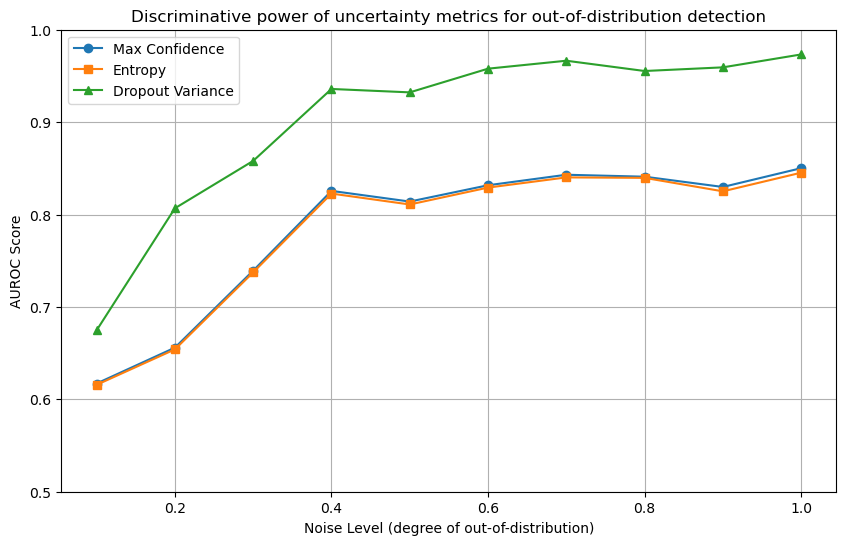

In [6]:
# evaluate quality of uncertainty estimate in correctly classifying corrupted data
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Store metrics for plotting
noise_levels = []
auroc_max_conf = []
auroc_entropy = []
auroc_mc_var = []

for noise_level, X_test in test_data.items():
    if noise_level == 'clean':
        continue
        
    noise_levels.append(noise_level)

    # Create true labels using test_indices
    is_corrupted = np.zeros(len(X_test))
    # Use pandas index matching
    corrupted_mask = X_test.index.isin(test_indices)
    is_corrupted[corrupted_mask] = 1
        
    # Get MC dropout predictions and uncertainty estimates
    preds_mc = model.predict_proba_mc(X_test, T=200)
    mc_var = preds_mc.var(axis=0)
    sample_variances = mc_var.sum(axis=1)

    # get predictions without MC dropout
    preds_eval = model.predict_proba(X_test)
    max_confidences = preds_eval.max(axis=1)
    # entropy
    entropies = -np.sum(preds_eval * np.log(preds_eval + 1e-10), axis=1)
    
    # Calculate AUROC for the three uncertainty metrics
    auroc_max_conf.append(roc_auc_score(is_corrupted, 1-max_confidences))
    auroc_entropy.append(roc_auc_score(is_corrupted, entropies))
    auroc_mc_var.append(roc_auc_score(is_corrupted, sample_variances))

# Plot results
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(noise_levels, auroc_max_conf, 'o-', label='Max Confidence')
plt.plot(noise_levels, auroc_entropy, 's-', label='Entropy') 
plt.plot(noise_levels, auroc_mc_var, '^-', label='Dropout Variance')
plt.xlabel('Noise Level (degree of out-of-distribution)')
plt.ylabel('AUROC Score')
plt.ylim(0.5,1)
plt.title('Discriminative power of uncertainty metrics for out-of-distribution detection')
plt.legend()
plt.grid(True)
plt.savefig("figures/AUROC_OOD_detection.png", dpi=600)
